# Data Science Project

### Content
1. Loading the libraries
2. Task 1: Understanding and analyzing the data
3. Task 2: Defining a possible business potential
4. Task 3: Developing a predictive model
5. Task 4: Analysing the result

## 1. Loading the libraries

In [211]:
%matplotlib inline
import numpy as np # For numerical calculations
import pandas as pd # For handling the data 
import pandas.io.sql as sqlio # For reading the data from the database into a pandas dataframe
from statsmodels.tsa.stattools import adfuller # For Dickey-Fuller Stationarity Test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt # For plotting
plt.rcParams['figure.figsize'] = [15, 7] # For bigger plots
plt.style.use('fivethirtyeight') # Special style template for matplotlib, highly useful for visualizing time series data

In [2]:
!pip install psycopg2

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import psycopg2 # For handling the PostgresSQL database

## 2. Task 1: Understanding and analyzing the data

Accessing the database that was restored from the Historical Gas Station Information from 2.5.2016 till 27.7.2018 using pgAdmin

In [4]:
try:
    conn = psycopg2.connect("dbname='datascience_database' user='postgres' host='localhost' password='amina'")
except:
    print("I am unable to connect to the database")

The next step is to define a cursor to work with

In [5]:
cur = conn.cursor()

In [6]:
def execute_query(connection, command="", chunksize=None):
    try:
        data = sqlio.read_sql_query(command, connection, chunksize=chunksize)
        return data
    except Exception as e: 
        print("Error:")
        print(e)
        conn.rollback()
        return None

#### How many different locations are present in the data ?

In [8]:
command = """
SELECT COUNT(DISTINCT place) AS "number of different locations present in the data"
FROM gas_station"""

number_of_locations = execute_query(conn, command)
print(number_of_locations)

   number of different locations present in the data
0                                               7068


#### How many different brands are there?


In [9]:
command = """
SELECT COUNT(DISTINCT brand) AS "number of different brands present in the data"
FROM gas_station
"""

number_of_brands = execute_query(conn, command)
print(number_of_brands)

   number of different brands present in the data
0                                             892


#### What is the min, max price for each gasoline type, per month?

In [69]:
command = """
SELECT to_char(date, 'YYYY-MM') AS "YYYY-MM",
       MIN(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) AS "Minimum Price Diesel",
       MIN(CASE WHEN e5 <= 0 THEN Null ELSE e5 END) AS "Minimum Price E5",
       MIN(CASE WHEN e10 <= 0 THEN Null ELSE e10 END) AS "Minimum Price E10",
       MAX(diesel) AS "Maximum Price Diesel",
       MAX(e5) AS "Maximum Price E5",
       MAX(e10) AS "Maximum Price E10"
FROM gas_station_information_history
GROUP BY "YYYY-MM"
ORDER BY "YYYY-MM" ASC
"""

min_max_prices = execute_query(conn, command)
print(min_max_prices)

    YYYY-MM  Minimum Price Diesel  Minimum Price E5  Minimum Price E10  \
0   2016-05                   869               989                999   
1   2016-06                   909              1000                919   
2   2016-07                   919               999                999   
3   2016-08                   899               979                989   
4   2016-09                   869              1000               1000   
5   2016-10                   889              1000               1069   
6   2016-11                   918               889                890   
7   2016-12                   869               890                870   
8   2017-01                   999               990                980   
9   2017-02                   889               990               1000   
10  2017-03                   989               999                939   
11  2017-04                   879               939                919   
12  2017-05                   919     

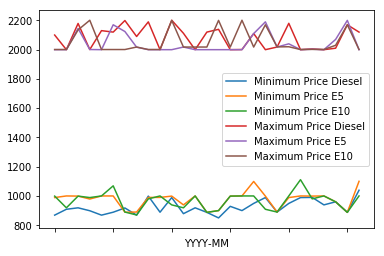

In [71]:
min_max_prices.plot(x='YYYY-MM')

#### What is the average price for each gasoline type per month?

In [72]:
command = """
SELECT to_char(date, 'YYYY-MM') AS "YYYY-MM",
       AVG(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) AS "Average Price Diesel",
       AVG(CASE WHEN e5 <= 0 THEN Null ELSE e5 END) AS "Average Price E5",
       AVG(CASE WHEN e10 <= 0 THEN Null ELSE e10 END) AS "Average Price E10"
FROM gas_station_information_history
GROUP BY "YYYY-MM"
ORDER BY "YYYY-MM" ASC
"""

average_prices = execute_query(conn, command)
print(average_prices)

    YYYY-MM  Average Price Diesel  Average Price E5  Average Price E10
0   2016-05           1087.821241       1325.056720        1305.625562
1   2016-06           1114.740873       1345.655654        1326.223515
2   2016-07           1093.364029       1310.480633        1290.973139
3   2016-08           1082.392376       1299.441619        1279.970337
4   2016-09           1096.066272       1313.668451        1294.182831
5   2016-10           1139.524781       1341.746035        1322.249217
6   2016-11           1122.387543       1316.700691        1297.177042
7   2016-12           1178.680864       1367.872787        1348.368262
8   2017-01           1190.852470       1388.811741        1368.933179
9   2017-02           1189.449398       1397.160024        1376.301935
10  2017-03           1166.161016       1365.074847        1341.811716
11  2017-04           1172.091239       1391.813490        1368.660299
12  2017-05           1140.794963       1363.143901        1340.179165
13  20

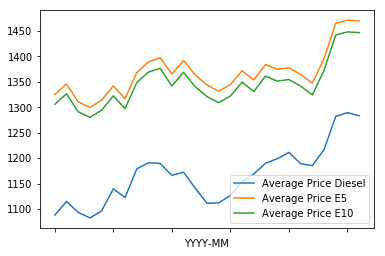

In [73]:
average_prices.plot(x='YYYY-MM')

#### What is the average price for each gasoline type per year?

In [36]:
command = """
SELECT extract(year from date) as Year,
       AVG(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) AS "Average Price Diesel",
       AVG(CASE WHEN e5 <= 0 THEN Null ELSE e5 END) AS "Average Price E5",
       AVG(CASE WHEN e10 <= 0 THEN Null ELSE e10 END) AS "Average Price E10"
FROM gas_station_information_history
GROUP BY Year
ORDER BY Year ASC
"""

avg_price_year = execute_query(conn, command)
print(avg_price_year)

     year  Average Price Diesel  Average Price E5  Average Price E10
0  2016.0           1115.301556       1327.569044        1308.091015
1  2017.0           1159.223592       1366.209625        1343.722027
2  2018.0           1235.246336       1411.025000        1388.051802


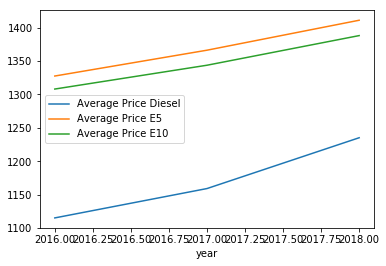

In [74]:
avg_price_year.plot(x='year')

#### What is the difference between min and max price for each gasoline type per month?

In [75]:
command = """
SELECT to_char(date, 'YYYY-MM') AS "YYYY-MM",
       MAX(diesel) - MIN(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) AS "MAX - MIN Diesel",
       MAX(e5) - MIN(CASE WHEN e5 <= 0 THEN Null ELSE e5 END) AS "MAX - MIN E5",
       MAX(e10) - MIN(CASE WHEN e10 <= 0 THEN Null ELSE e10 END) AS "MAX - MIN E10"
FROM gas_station_information_history
GROUP BY "YYYY-MM"
ORDER BY "YYYY-MM" ASC
"""

min_max_difference = execute_query(conn, command)
print(min_max_difference)

    YYYY-MM  MAX - MIN Diesel  MAX - MIN E5  MAX - MIN E10
0   2016-05              1230          1010           1001
1   2016-06              1090           999           1081
2   2016-07              1259          1145           1135
3   2016-08              1101          1021           1211
4   2016-09              1260           999           1000
5   2016-10              1230          1169            931
6   2016-11              1280          1234           1110
7   2016-12              1220          1126           1147
8   2017-01              1190          1009           1020
9   2017-02              1110          1009           1000
10  2017-03              1211          1000           1260
11  2017-04              1232          1078           1098
12  2017-05              1080           999           1017
13  2017-06              1231          1111           1129
14  2017-07              1288          1099           1299
15  2017-08              1070          1000           10

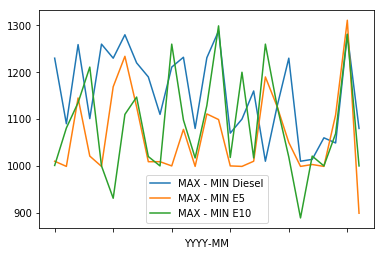

In [76]:
min_max_difference.plot(x='YYYY-MM')

#### What is the standard deviation of each gasoline price?

In [25]:
command = """
SELECT STDDEV(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) AS "Standard Deviation Diesel",
       STDDEV(CASE WHEN e5 <= 0 THEN Null ELSE e5 END) AS "Standard Deviation E5",
       STDDEV(CASE WHEN e10 <= 0 THEN Null ELSE e10 END) AS "Standard Deviation E10"
FROM gas_station_information_history
"""

price_std = execute_query(conn, command)
print(price_std)

   Standard Deviation Diesel  Standard Deviation E5  Standard Deviation E10
0                  75.510968              65.796325               66.486682


#### What is the distribution of the gasoline prices?

In [ ]:
command = """
SELECT (CASE WHEN diesel <= 0 THEN Null ELSE diesel END)
FROM gas_station_information_history
"""

low = np.inf
high = -np.inf

nbins = 6

reader = execute_query(conn, command, 5000)
for chunk in reader:
    low = np.minimum(chunk.iloc[:].min(), low)
    high = np.maximum(chunk.iloc[:].max(), high)
    
bin_edges = np.linspace(low, high, nbins + 1)
total = np.zeros(nbins, np.uint)

reader = execute_query(conn, command, 5000)
for chunk in reader:
    chunk.fillna(method='ffill', inplace=True)
    subtotal, e = np.histogram(chunk.iloc[:], bins=bin_edges)
    total += subtotal.astype(np.uint)
    del chunk
    
plt.bar(bin_edges[:-1], total, width=1)

In [ ]:
command = """
SELECT (CASE WHEN e5 <= 0 THEN Null ELSE e5 END)
FROM gas_station_information_history
"""

low = np.inf
high = -np.inf

nbins = 6

reader = execute_query(conn, command, 5000)
for chunk in reader:
    low = np.minimum(chunk.iloc[:].min(), low)
    high = np.maximum(chunk.iloc[:].max(), high)
    
bin_edges = np.linspace(low, high, nbins + 1)
total = np.zeros(nbins, np.uint)

reader = execute_query(conn, command, 5000)
for chunk in reader:
    subtotal, e = np.histogram(chunk.iloc[:], bins=bin_edges)
    total += subtotal.astype(np.uint)
    print(subtotal)
    print(e)
    print(total)
    
plt.bar(bin_edges[:-1], total, width=1)

In [ ]:
command = """
SELECT (CASE WHEN e10 <= 0 THEN Null ELSE e10 END)
FROM gas_station_information_history
"""

low = np.inf
high = -np.inf

nbins = 6

reader = execute_query(conn, command, 5000)
for chunk in reader:
    low = np.minimum(chunk.iloc[:].min(), low)
    high = np.maximum(chunk.iloc[:].max(), high)
    
bin_edges = np.linspace(low, high, nbins + 1)
total = np.zeros(nbins, np.uint)

reader = execute_query(conn, command, 5000)
for chunk in reader:
    subtotal, e = np.histogram(chunk.iloc[:], bins=bin_edges)
    total += subtotal.astype(np.uint)
    print(subtotal)
    print(e)
    print(total)
    
plt.bar(bin_edges[:-1], total, width=1)

## Task 2: Defining a possible business potential

Here are some possible ideas on how to use gas prices to the benefit of the company:
1. Increase trucks' travalled distances during periods of the year in which gasoline prices are cheaper and vice versa.
2. Select gas stations on the same road/path that offer cheaper gasoline prices.
3. Select roads/paths where there are gas stations that offer cheaper gasoline prices.
4. Prevent trucks from driving during rush hours.
5. Use trucks that consume the cheapest gasoline type more often than other trucks.

We will proceed with idea No.1 which is to increase trucks' travalled distances during periods of the year in which gasoline prices are cheaper and vice versa.

According to [this article](https://www.theicct.org/sites/default/files/publications/ICCT_HDV_FC_lit-review_20150209.pdf), the average truck consumption for the year 2013 in the European Union is of 38 L per 100 km.

According to the historical gasoline prices data, the average price per liter for the year 2017 for Diesel, E5 and E10 is 1.159€, 1.366€ and 1.343€ respectively.

According to the given information the company has a truck fleet (100) with an average milage per truck and year of 220000 km and operates in Germany. Which means that each truck has an average monthly milage of 18333 km and that corresponds to an average monthly fuel consumption of 6966.54 L.

In [100]:
command = """
SELECT to_char(date, 'YYYY-MM') AS "YYYY-MM",
       AVG(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) AS "Average Price Diesel",
       AVG(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) * 6966.54 AS "Average Cost"
FROM gas_station_information_history
WHERE extract(year from date) = 2017
GROUP BY "YYYY-MM"
ORDER BY "YYYY-MM"
"""

average_prices_basic = execute_query(conn, command)
print(average_prices_basic)

    YYYY-MM  Average Price Diesel  Average Cost
0   2017-01           1190.852470  8.296121e+06
1   2017-02           1189.449398  8.286347e+06
2   2017-03           1166.161016  8.124107e+06
3   2017-04           1172.091239  8.165421e+06
4   2017-05           1140.794963  7.947394e+06
5   2017-06           1111.201157  7.741227e+06
6   2017-07           1112.030148  7.747003e+06
7   2017-08           1126.363070  7.846853e+06
8   2017-09           1153.476767  8.035742e+06
9   2017-10           1168.880754  8.143055e+06
10  2017-11           1189.880015  8.289347e+06
11  2017-12           1198.693146  8.350744e+06


Using these assumptions, we obtain a yearly fuel cost for one truck of:

In [108]:
print("{:.2f}€".format(average_prices_basic["Average Cost"].sum()))

96973360.01€


And for the entire fleet:

In [109]:
print("{:.2f}€".format(average_prices_basic["Average Cost"].sum() * 100))

9697336000.84€


This time, we reuse most of the previous assumptions but instead having the same average milage per month we adapt it according to the average fuel price per month.

In [105]:
command = """
SELECT to_char(date, 'YYYY-MM') AS "YYYY-MM",
       AVG(CASE WHEN diesel <= 0 THEN Null ELSE diesel END) AS "Average Price Diesel"
FROM gas_station_information_history
WHERE extract(year from date) = 2017
GROUP BY "YYYY-MM"
ORDER BY "YYYY-MM"
"""

average_prices_smart = execute_query(conn, command)
average_prices_smart["Adaptive Milage (km)"] = 1 / average_prices_smart["Average Price Diesel"] * 220000 / ( 1 / average_prices_smart["Average Price Diesel"]).sum()
average_prices_smart["Fuel (L)"] = average_prices_smart["Adaptive Milage (km)"] * 38 / 100
average_prices_smart["Cost (€)"] = average_prices_smart["Average Price Diesel"] * average_prices_smart["Fuel (L)"]
print(average_prices_smart)

    YYYY-MM  Average Price Diesel  Adaptive Milage (km)     Fuel (L)  \
0   2017-01           1190.852470          17846.233043  6781.568556   
1   2017-02           1189.449398          17867.284418  6789.568079   
2   2017-03           1166.161016          18224.096334  6925.156607   
3   2017-04           1172.091239          18131.891086  6890.118612   
4   2017-05           1140.794963          18629.316734  7079.140359   
5   2017-06           1111.201157          19125.457677  7267.673917   
6   2017-07           1112.030148          19111.200106  7262.256040   
7   2017-08           1126.363070          18868.010911  7169.844146   
8   2017-09           1153.476767          18424.498256  7001.309337   
9   2017-10           1168.880754          18181.692715  6909.043232   
10  2017-11           1189.880015          17860.818259  6787.110938   
11  2017-12           1198.693146          17729.500461  6737.210175   

        Cost (€)  
0   8.075848e+06  
1   8.075848e+06  
2   8.

We obtain a yearly fuel cost for one truck of:

In [110]:
print("{:.2f}€".format(average_prices_smart["Cost (€)"].sum()))

96910171.95€


And for the entire fleet:

In [111]:
print("{:.2f}€".format(average_prices_smart["Cost (€)"].sum() * 100))

9691017195.16€


After taking into consideration both cases, we notice that using our suggested idea could save the company around 6 million € per year.

## Task 3: Developing a predictive model

Without loss of generality, we will train a model to predict the price of Diesel only.

Before training model we have to pre-process the data. We do the following operations:
1. Fill in the missing values
2. Stationarity check
3. Feature extraction
4. Split the data into a training set and a test set
5. Normalize the training data

#### Filling in the missing values

In [ ]:
command = """
SELECT to_char(date, 'YYYY-MM-DD') AS "YYYY-MM-DD",
       AVG(CASE WHEN diesel <= 0 THEN Null ELSE diesel END)
FROM gas_station_information_history
GROUP BY "YYYY-MM-DD"
ORDER BY "YYYY-MM-DD" ASC
LIMIT 10
OFFSET 0
"""

diesel_prices = execute_query(conn, command)

In [222]:
diesel_prices = diesel_prices.fillna(method='ffill')

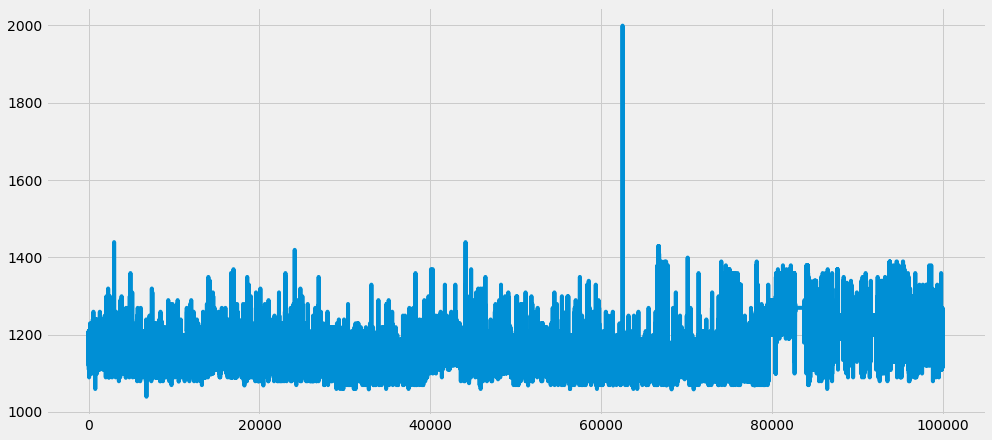

In [223]:
diesel_prices["diesel"].plot()

#### Stationarity

In [224]:
def test_stationarity(data, window=30):
    # Determing rolling statistics
    rolmean = data.rolling(window=window, center=False).mean()
    rolstd = data.rolling(window=window, center=False).std()

    # Plot rolling statistics:
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

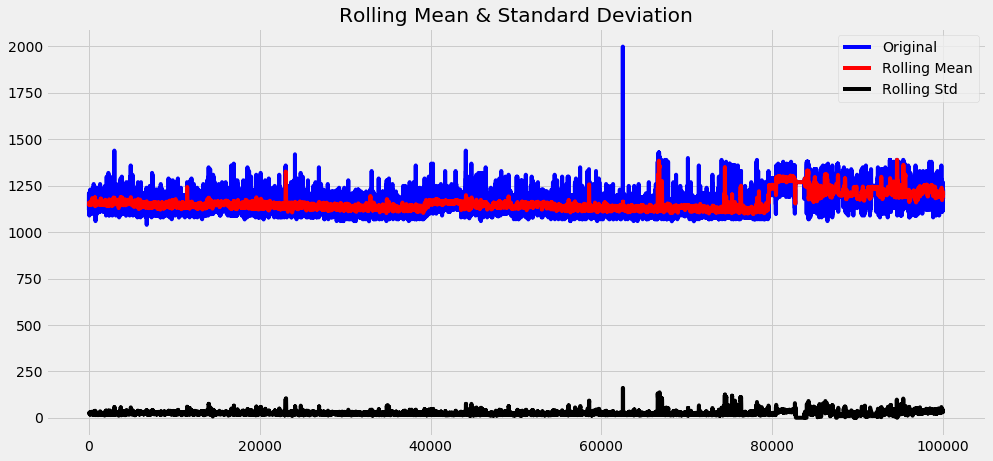

Results of Dickey-Fuller Test:
Test Statistic                -9.008886e+00
p-value                        6.203096e-15
#Lags Used                     6.800000e+01
Number of Observations Used    9.993100e+04
Critical Value (1%)           -3.430415e+00
Critical Value (5%)           -2.861569e+00
Critical Value (10%)          -2.566785e+00
dtype: float64


In [225]:
test_stationarity(data=diesel_prices["diesel"])

Test Statistic < Critical Value (1%), that tells us that we are 99% confident that this series is stationary.

#### Feature extraction

In [226]:
# Adding the lag of the target variable from 1 steps back up to 5
for i in range(1, 6):
    diesel_prices["lag_{}".format(i)] = diesel_prices["diesel"].shift(i)

#### Splitting the dataset

In [227]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [228]:
y = diesel_prices.dropna()["diesel"]
X = diesel_prices.dropna().drop(["diesel"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

#### Normalizing the training data

In [229]:
X_minimum = X_train.min()
X_maximum = X_train.max()
X_train_norm = (X_train - X_minimum) / (maximum - X_minimum)
y_minimum = y_train.min()
y_maximum = y_train.max()
y_train_norm = (y_train - y_minimum) / (y_maximum - y_minimum)

We check the correlation between our features to see if we can drop some of them or not.

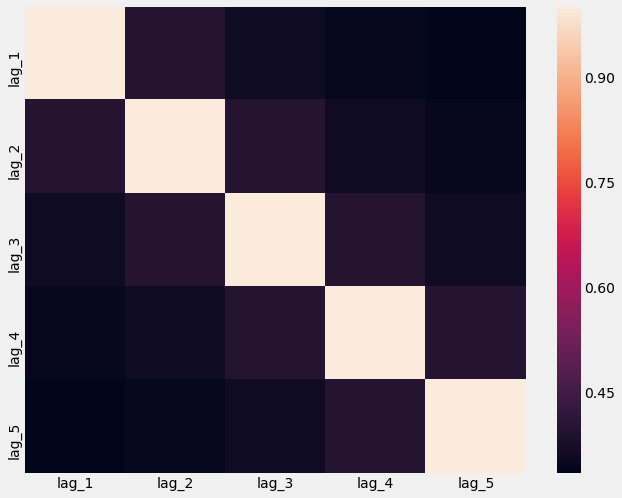

In [230]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_norm.corr());

### Training the Models

In [231]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

# Training the linear regressor
lr = LinearRegression()
lr.fit(X_train_norm, y_train_norm)

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_norm, y_train_norm)

lasso = LassoCV(cv=tscv)
lasso.fit(X_train_norm, y_train_norm)

xgb = XGBRegressor()
xgb.fit(X_train_norm, y_train_norm)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## 5. Task 4: Analyzing the results

In [234]:
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
            
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    MAPE = mean_absolute_percentage_error(prediction, y_test)
    R2 = r2_score(y_test, prediction)
    MSE = mean_squared_error(y_test, prediction)
    plt.title("MAPE:{:.2f}%, R2:{:.3f}, MSE:{:.3f}".format(MAPE, R2, MSE))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

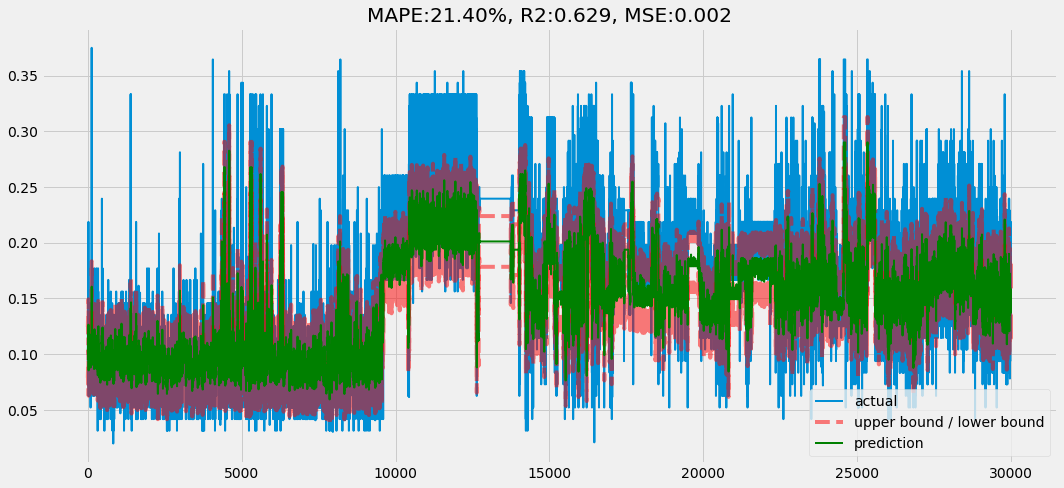

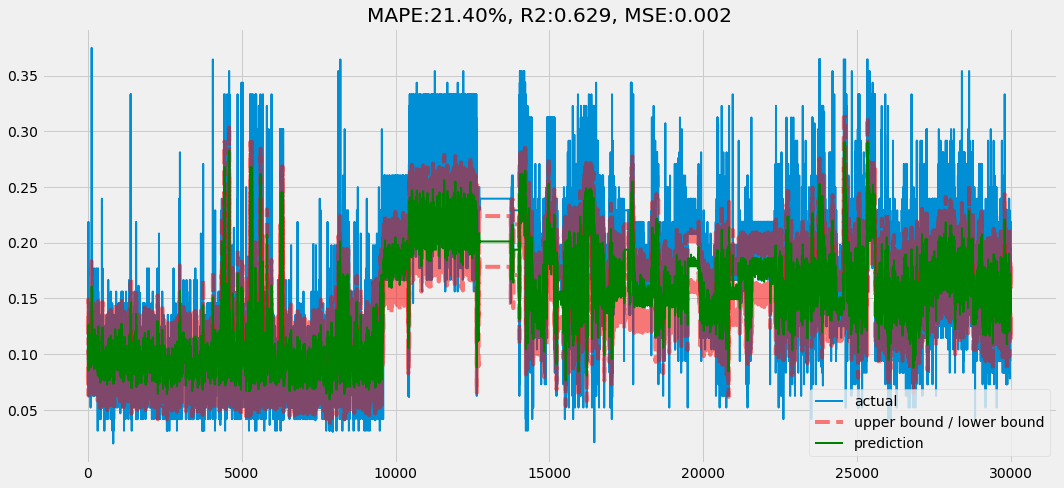

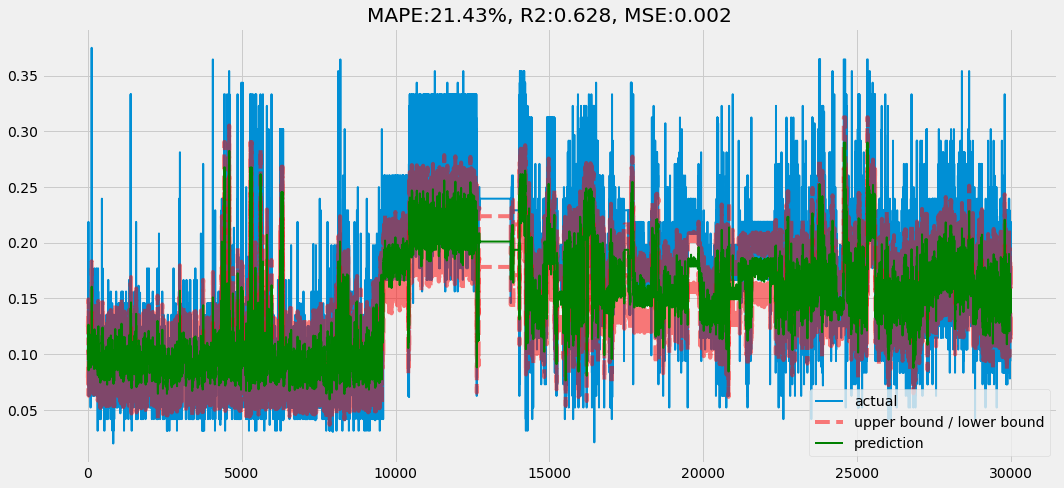

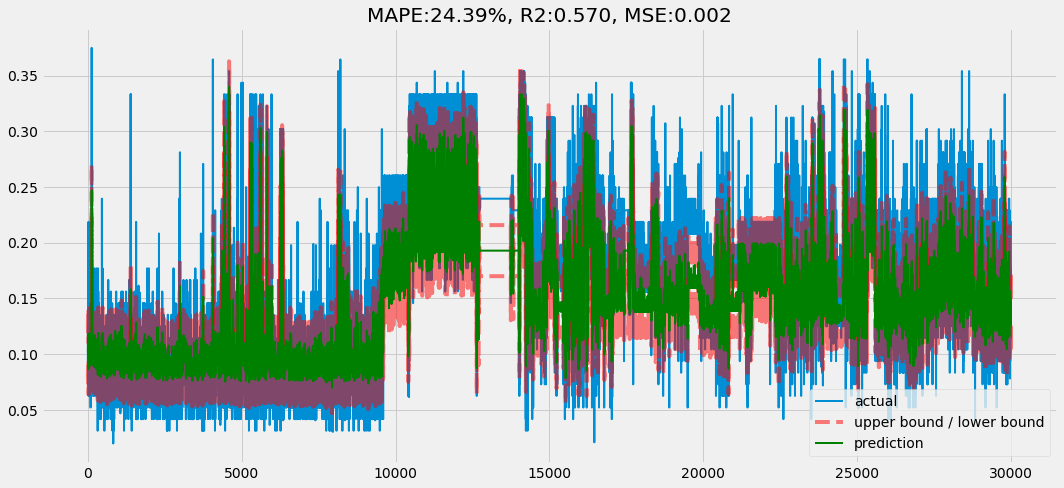

In [235]:
X_test_norm = (X_test - X_minimum) / (maximum - X_minimum)
y_test_norm = (y_test - y_minimum) / (y_maximum - y_minimum)

plotModelResults(lr, X_train_norm, X_test_norm, y_train_norm, y_test_norm, plot_intervals=True)

plotModelResults(ridge, X_train_norm, X_test_norm, y_train_norm, y_test_norm, plot_intervals=True)

plotModelResults(lasso, X_train_norm, X_test_norm, y_train_norm, y_test_norm, plot_intervals=True)

plotModelResults(xgb, X_train_norm, X_test_norm, y_train_norm, y_test_norm, plot_intervals=True)

For our trained models we used linear regression, RidgeCV, LassoCV and XGBRegressor models and we saved 30% data for testing.  Important measurements for quality of predictions are: MAPE(mean absolute percentage error), R squared (coefficient of determination (in econometrics it can be interpreted as a percentage of variance explained by the model)) and MSE(mean squared error). According to our results, XGBRegressor gives us the worse results because MAPE is higher and R squared lower than with other models. LassoCV is second worse because of a bit lower R squared and a bit higher MAPE, while linear regression and RidgeCV obtain the same results.